In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
os.environ["PYTHONHASHSEED"] = "0"
np.random.seed(0)
# --- KROK 1: Konfiguracja i Wczytanie Danych (bez zmian) ---

current_dir = os.getcwd()
src_dir = os.path.dirname(os.path.dirname(current_dir))
project_root = os.path.dirname(src_dir)

if project_root not in sys.path:
    sys.path.insert(0, project_root)
if src_dir not in sys.path:
    sys.path.insert(0, src_dir) 
    
from src.helpers.file_utils import FileUtils
from src.helpers.logger import info, error

info("Rozpoczynam proces trenowania ZAAWANSOWANEGO modelu Stacking.")

PROCESSED_DATA_DIR = os.path.join(FileUtils.get_project_root(), 'ProcessedForModeling')
RAW_DATA_PATH = os.path.join(FileUtils.get_project_root(), 'Data', 'DataSet', 'real_madrid_master_dataset_win.csv')
DATA_DIR = os.path.join(FileUtils.get_project_root(), 'Data')
try:
    X_train = FileUtils.load_csv_safe(os.path.join(PROCESSED_DATA_DIR, 'X_train.csv'))
    y_train = FileUtils.load_csv_safe(os.path.join(PROCESSED_DATA_DIR, 'y_train.csv')).values.ravel()
    X_test = FileUtils.load_csv_safe(os.path.join(PROCESSED_DATA_DIR, 'X_test.csv'))
    y_test = FileUtils.load_csv_safe(os.path.join(PROCESSED_DATA_DIR, 'y_test.csv')).values.ravel()
    master_df = FileUtils.load_csv_safe(RAW_DATA_PATH)
    num_test_samples = len(X_test)
    test_metadata = master_df[['MATCH_ID','M_DATE', 'SEASON', 'OPP_ID' ,'is_real_madrid_win']].tail(num_test_samples).reset_index(drop=True)
    info("Dane i metadane wczytane i zsynchronizowane pomyślnie.")
except FileNotFoundError as e:
    error(f"Nie znaleziono pliku: {e.filename}. Sprawdź ścieżki.")
    sys.exit(1)


INFO: Rozpoczynam proces trenowania ZAAWANSOWANEGO modelu Stacking.
INFO: Dane i metadane wczytane i zsynchronizowane pomyślnie.


In [2]:
# --- KROK 2: Ręczny Stacking (walidacja czasowa, bez wycieku) ---

info("Rozpoczynam ręczny proces stackingu (time-based, bez wycieku)...")

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Modele bazowe – deterministyczne ustawienia (bez random_state) + skalowanie
lasso = make_pipeline(
    StandardScaler(),
    LassoCV(cv=5, max_iter=10000)
)
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=5,
    min_samples_leaf=3,
    bootstrap=False,     # brak bootstrapu -> deterministycznie
    max_features=1.0,    # brak losowego wyboru cech
    n_jobs=1
)
ridge = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=np.logspace(-2, 5, 50))
)

base_estimators = [lasso, rf, ridge]

# Meta-model XGB – bez losowości (brak subsamplingu), wzmocniony
meta_model_xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=400,
    max_depth=3,
    learning_rate=0.05,
    subsample=1.0,
    colsample_bytree=1.0,
    min_child_weight=1.0,
    reg_lambda=1.0,
    reg_alpha=0.0,
    gamma=0.0,
    n_jobs=1,
    tree_method="hist",
    enable_categorical=False
)

# Pomocnicze
def _take_rows(X, idx):
    return X.iloc[idx] if hasattr(X, "iloc") else X[idx]

def make_forward_splits(n_samples, n_splits=5, min_train_frac=0.2):
    """
    Tworzy forward-chaining splity: [0:train_end) -> [train_end:test_end)
    Pokrywa cały ogon po minimalnym oknie treningowym, bez wycieku.
    """
    min_train = max(1, int(n_samples * min_train_frac))
    remain = n_samples - min_train
    if remain <= 1:
        return [(np.arange(0, n_samples-1), np.arange(n_samples-1, n_samples))]
    n_splits = min(n_splits, remain)  # każdy test ma >=1 próbkę
    base = remain // n_splits
    extra = remain % n_splits
    splits = []
    start = min_train
    for i in range(n_splits):
        test_len = base + (1 if i < extra else 0)
        train_end = start
        test_start = train_end
        test_end = test_start + test_len
        train_idx = np.arange(0, train_end)
        test_idx = np.arange(test_start, test_end)
        splits.append((train_idx, test_idx))
        start = test_end
    return splits

def forward_oof_predict(estimator, X, y, splits):
    """
    OOF bez wycieku: fit na train_idx, predict na test_idx; zwraca wektor o długości y z NaN dla próbek bez predykcji.
    """
    oof = np.full(len(y), np.nan, dtype=float)
    for tr_idx, te_idx in splits:
        est = clone(estimator)
        est.fit(_take_rows(X, tr_idx), y[tr_idx])
        oof[te_idx] = est.predict(_take_rows(X, te_idx))
    return oof

# 1) Splity czasowe do OOF: gęste (test_len = 1)
min_train_frac = 0.300  # większe okno startowe zwykle stabilizuje
n_samples = len(X_train)
min_train = max(1, int(n_samples * min_train_frac))
remain = n_samples - min_train
n_splits_dense = max(1, remain)  # każdy krok 1 próbka
splits = make_forward_splits(n_samples, n_splits=n_splits_dense, min_train_frac=min_train_frac)
info(f"Zbudowano {len(splits)} forward splitów (min_train_frac={min_train_frac}).")

# 2) Meta-cechy OOF dla zbioru treningowego (bez wycieku)
info("Generowanie meta-cech (OOF) dla zbioru treningowego...")
oof_list = [forward_oof_predict(est, X_train, y_train, splits) for est in base_estimators]
meta_features_train = np.column_stack(oof_list)

# zachowaj tylko wiersze z kompletnymi predykcjami
valid_mask = ~np.isnan(meta_features_train).any(axis=1)
meta_features_train = meta_features_train[valid_mask]

info(f"OOF: zachowano {int(valid_mask.sum())}/{len(valid_mask)} próbek do trenowania meta-modelu.")

# 3) Korekta celu tylko dla próbek w valid_mask (zgodnie z Twoją logiką)
info("Stosowanie stałej korekty celu dla meta-modelu...")
y_train_adjusted = y_train.copy()

correction_value_for_bigger_courses = 0.85
correction_value_for_lower_courses = 0.95

bigger_odds_indices = (y_train >= 1.30) & (y_train <= 1.60)
lower_odds_indices = (y_train < 1.30)

y_train_adjusted[bigger_odds_indices] *= correction_value_for_bigger_courses
y_train_adjusted[lower_odds_indices] *= correction_value_for_lower_courses

# dopasuj cel do OOF
y_meta = y_train_adjusted[valid_mask].ravel()

info(f"Obniżono cel dla {int(np.sum(bigger_odds_indices))} (większe kursy) i {int(np.sum(lower_odds_indices))} (mniejsze kursy) próbek.")

# 4) Trening meta-modelu na OOF (bez wycieku)
info("Trenowanie meta-modelu...")
# sanity check dopasowania kształtów
assert meta_features_train.shape[0] == y_meta.shape[0], f"Shape mismatch: X:{meta_features_train.shape} y:{y_meta.shape}"
meta_model_xgb.fit(meta_features_train, y_meta)

# 5) Meta-cechy dla zbioru testowego: bazowe fit na CAŁYM treningu, predykcje na teście
info("Generowanie meta-cech dla zbioru testowego...")
trained_base_full = [clone(est).fit(X_train, y_train) for est in base_estimators]
meta_features_test = np.column_stack([est.predict(X_test) for est in trained_base_full])

# 6) Końcowe predykcje
info("Generowanie końcowych predykcji...")
y_pred_stack = meta_model_xgb.predict(meta_features_test)
info("Proces ręcznego stackingu zakończony.")

INFO: Rozpoczynam ręczny proces stackingu (time-based, bez wycieku)...
INFO: Zbudowano 101 forward splitów (min_train_frac=0.3).
INFO: Generowanie meta-cech (OOF) dla zbioru treningowego...


INFO: OOF: zachowano 101/144 próbek do trenowania meta-modelu.
INFO: Stosowanie stałej korekty celu dla meta-modelu...
INFO: Obniżono cel dla 61 (większe kursy) i 25 (mniejsze kursy) próbek.
INFO: Trenowanie meta-modelu...
INFO: Generowanie meta-cech dla zbioru testowego...
INFO: Generowanie końcowych predykcji...
INFO: Proces ręcznego stackingu zakończony.


In [3]:
# ...existing code...
# --- KROK 3: Ewaluacja Statystyczna  ---
mse_stack = mean_squared_error(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)  # NEW: MAE
r2_stack = r2_score(y_test, y_pred_stack)
rmse_stack = float(np.sqrt(mse_stack))  # NEW: RMSE

info("\n" + "="*60)
info("WYNIKI EWALUACJI STATYSTYCZNEJ (Przed kalibracją)")
info("="*60)
info(f"Błąd średniokwadratowy (MSE): {mse_stack:.4f}")
info(f"Błąd pierwiastkowy (RMSE): {rmse_stack:.4f}")  # NEW
info(f"Błąd średni bezwzględny (MAE): {mae_stack:.4f}")  # NEW
info(f"Współczynnik determinacji (R^2): {r2_stack:.4f}")
info("="*60)

# --- KROK 3.5: Ewaluacja Biznesowa z Kalibracją Kursów ---

info("\n" + "="*60)
info("WYNIKI EWALUACJI BIZNESOWEJ (SYMULACJA FINANSOWA)")
info("="*60)

# 1. Kalibracja kursów, aby zapewnić sprawiedliwe porównanie (METODA PROPORCJONALNA)
mean_real_odds = np.mean(y_test)
mean_pred_odds_raw = np.mean(y_pred_stack)
info(f"Średni kurs rzeczywisty: {mean_real_odds:.4f}")
info(f"Średni kurs modelu (przed kalibracją): {mean_pred_odds_raw:.4f}")
# Obliczamy współczynnik mnożący zamiast odejmowanego
proportional_calibration_factor = mean_real_odds / mean_pred_odds_raw
# Mnożymy każdy kurs przez ten współczynnik
y_pred_calibrated = y_pred_stack * proportional_calibration_factor

INFO: 
INFO: WYNIKI EWALUACJI STATYSTYCZNEJ (Przed kalibracją)
INFO: ============================================================
INFO: Błąd średniokwadratowy (MSE): 0.0698
INFO: Błąd pierwiastkowy (RMSE): 0.2642
INFO: Błąd średni bezwzględny (MAE): 0.1654
INFO: Współczynnik determinacji (R^2): 0.6592
INFO: ============================================================
INFO: 
INFO: WYNIKI EWALUACJI BIZNESOWEJ (SYMULACJA FINANSOWA)
INFO: ============================================================
INFO: Średni kurs rzeczywisty: 1.5789
INFO: Średni kurs modelu (przed kalibracją): 1.4933


In [4]:
df = pd.DataFrame()
df['Real Course'] = y_test
df['Pred Cource before calibration'] = y_pred_stack.round(3)
df['Pred Cource after calibration'] = y_pred_calibrated.round(3)
df[' (W=1, R=0.5, P=0)'] = test_metadata['is_real_madrid_win'].values

for col in ['MATCH_ID','M_DATE', 'SEASON', 'OPP_ID']:
    if col in test_metadata.columns:
        df[col] = test_metadata[col].values
        
desired_first = ['MATCH_ID','M_DATE', 'SEASON', 'OPP_ID']
first_cols = [c for c in desired_first if c in df.columns]
other_cols = [c for c in df.columns if c not in first_cols]
df = df[first_cols + other_cols]

FileUtils.save_csv_safe(df, os.path.join(DATA_DIR, 'Model_result', 'PRED_odds_comparison_L+RGF+RCV.csv'))

True

In [5]:
# --- KROK 3.5: Ewaluacja Biznesowa z Kalibracją Kursów ---

info("\n" + "="*60)
info("WYNIKI EWALUACJI BIZNESOWEJ (SYMULACJA FINANSOWA)")
info("="*60)

# 1. Kalibracja kursów, aby zapewnić sprawiedliwe porównanie (METODA PROPORCJONALNA)
mean_real_odds = np.mean(y_test)
mean_pred_odds_raw = np.mean(y_pred_stack)
info(f"Średni kurs rzeczywisty: {mean_real_odds:.4f}")
info(f"Średni kurs modelu (przed kalibracją): {mean_pred_odds_raw:.4f}")

# Zabezpieczenie przed dzieleniem przez zero + obliczenie kursu po kalibracji
proportional_calibration_factor = (mean_real_odds / mean_pred_odds_raw) if mean_pred_odds_raw != 0 else 1.0
y_pred_calibrated = y_pred_stack * proportional_calibration_factor
mean_pred_odds_calibrated = float(np.mean(y_pred_calibrated))

INFO: 
INFO: WYNIKI EWALUACJI BIZNESOWEJ (SYMULACJA FINANSOWA)
INFO: ============================================================
INFO: Średni kurs rzeczywisty: 1.5789
INFO: Średni kurs modelu (przed kalibracją): 1.4933


INFO: 1. KALIBRACJA PROPORCJONALNA (Warunek Sprawiedliwości)
INFO:    - Średni kurs rzeczywisty:          1.5789
INFO:    - Średni kurs modelu (przed kal.):   1.4933
INFO:    - Zastosowany współczynnik kalibracji (mnożnik): 1.0573
INFO:    - Średni kurs modelu (po kal.):      1.5789
INFO:    - WNIOSEK: Kursy skalibrowane. Można przeprowadzić analizę finansową.
INFO: ------------------------------------------------------------
INFO: 2.1 ANALIZA WYPŁAT SUMY(dla 24 wygranych meczy)
INFO:    - Suma wypłat wg. kursów rzeczywistych: 35.73
INFO:    - Suma wypłat wg. kursów modelu:      36.46
INFO:    - Różnica (Oszczędność na wypłatach): kurs_prawdziwy:35.73 - kurs_modelu36.46 = -0.73
INFO:     - Real wygrał więc niski kurs na jego zwycięstwo oznacza niższą wygrana klienta
INFO:     - Celujemy w niską sume kursów na zwycięstwo wtedy kiedy Real wygrywa
INFO:    - WNIOSEK: Model jest GORSZY (wygenerowałby większe wypłaty).
INFO: ------------------------------------------------------------
INFO:

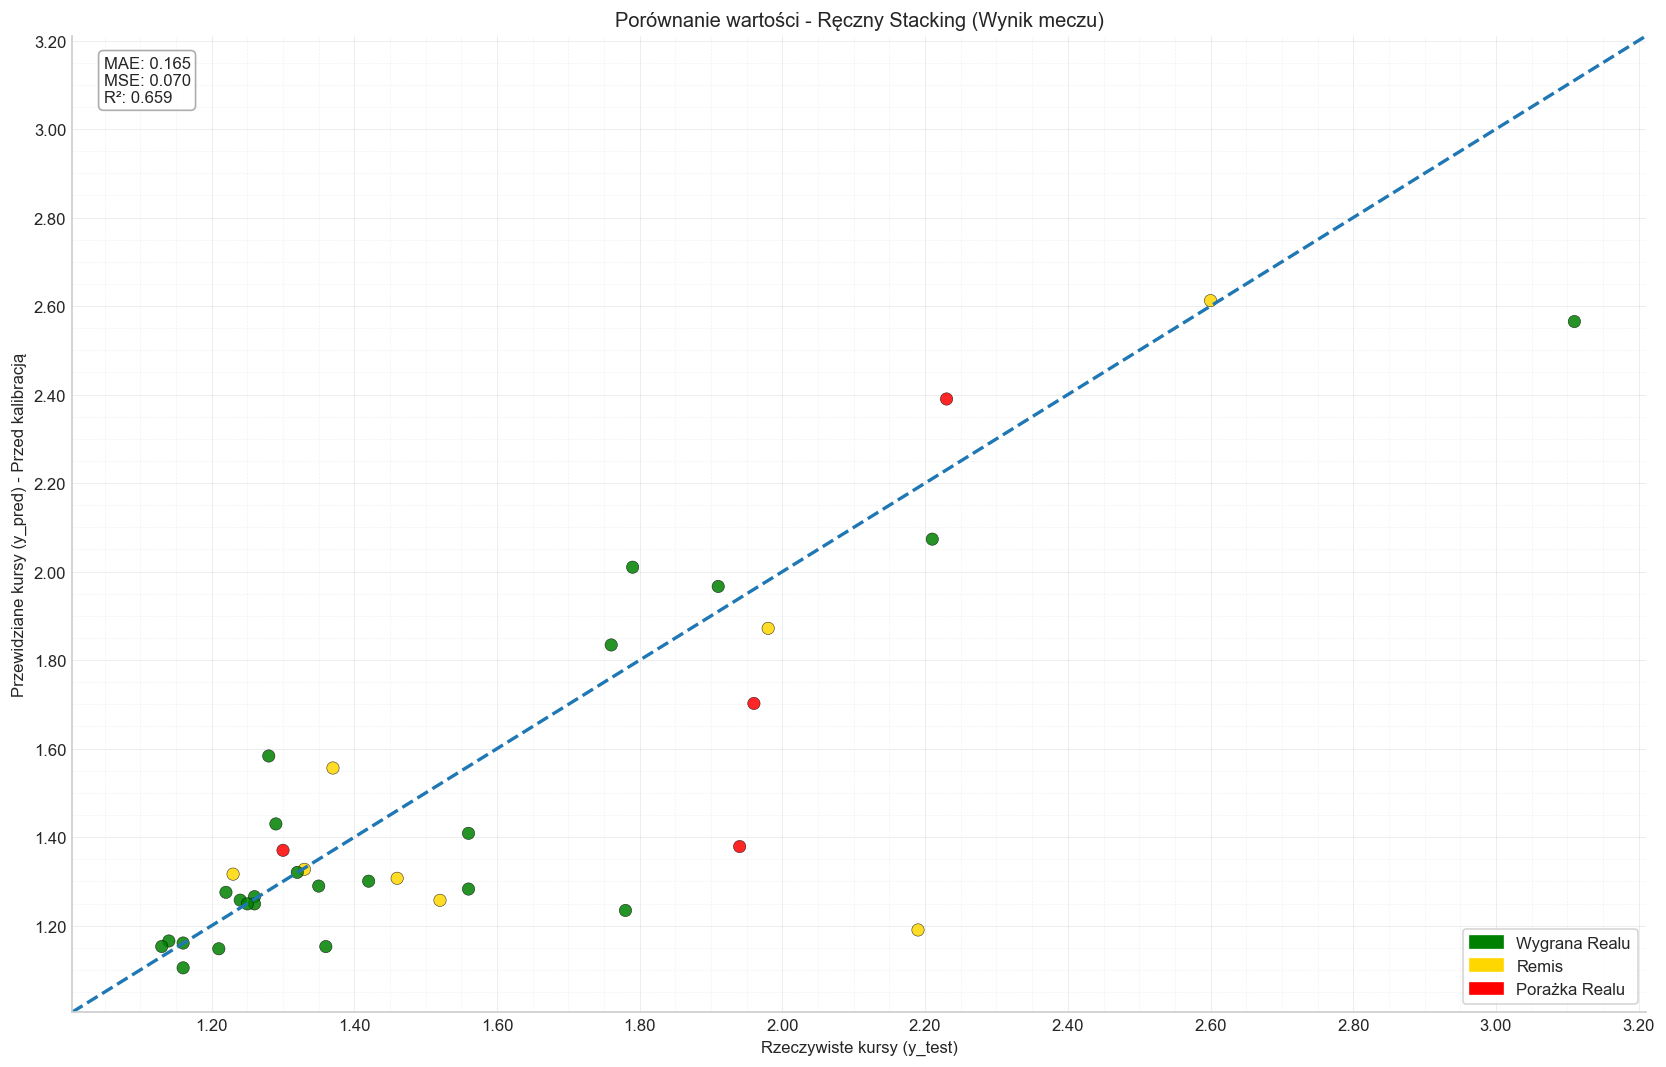

INFO: Skrypt zakończył działanie.


In [6]:
info(f"1. KALIBRACJA PROPORCJONALNA (Warunek Sprawiedliwości)")
info(f"   - Średni kurs rzeczywisty:          {mean_real_odds:.4f}")
info(f"   - Średni kurs modelu (przed kal.):   {mean_pred_odds_raw:.4f}")
info(f"   - Zastosowany współczynnik kalibracji (mnożnik): {proportional_calibration_factor:.4f}")
info(f"   - Średni kurs modelu (po kal.):      {mean_pred_odds_calibrated:.4f}")
info("   - WNIOSEK: Kursy skalibrowane. Można przeprowadzić analizę finansową.")
info("-"*60)

# 2. Analiza Wypłat (Mecze, które Real wygrał) - UŻYWAMY SKALIBROWANYCH KURSÓW
win_mask = (test_metadata['is_real_madrid_win'] == 1)
draw_or_loss_mask = (test_metadata['is_real_madrid_win'] != 1)
payout_real_wins = np.sum(y_test[win_mask])
payout_pred_wins = np.sum(y_pred_calibrated[win_mask])

payout_real_non_wins = np.sum(y_test[draw_or_loss_mask])
payout_pred_non_wins = np.sum(y_pred_calibrated[draw_or_loss_mask])

payout_difference_win = payout_real_wins - payout_pred_wins
payout_difference_non_win = payout_real_non_wins - payout_pred_non_wins


win_mask = (test_metadata['is_real_madrid_win'] == 1)
draw_or_loss_mask = (test_metadata['is_real_madrid_win'] != 1)
# ---------------------------------------------------------------------------------------------------------------
# ZAMIANA SUM NA ILOCZYNY
combined_real_wins = float(np.prod(y_test[win_mask])) if np.any(win_mask) else np.nan
combined_pred_wins = float(np.prod(y_pred_calibrated[win_mask])) if np.any(win_mask) else np.nan

combined_real_non_wins = float(np.prod(y_test[draw_or_loss_mask])) if np.any(draw_or_loss_mask) else np.nan
combined_pred_non_wins = float(np.prod(y_pred_calibrated[draw_or_loss_mask])) if np.any(draw_or_loss_mask) else np.nan

# Różnice (dla informacji) i bezpieczne ilorazy
payout_difference_win_2 = combined_real_wins - combined_pred_wins
payout_difference_non_win_2 = combined_real_non_wins - combined_pred_non_wins

wins_ratio = (combined_real_wins / combined_pred_wins) if (combined_pred_wins and combined_pred_wins != 0) else np.nan
non_wins_ratio = (combined_real_non_wins / combined_pred_non_wins) if (combined_pred_non_wins and combined_pred_non_wins != 0) else np.nan

info(f"2.1 ANALIZA WYPŁAT SUMY(dla {np.sum(win_mask)} wygranych meczy)")
info(f"   - Suma wypłat wg. kursów rzeczywistych: {payout_real_wins:.2f}")
info(f"   - Suma wypłat wg. kursów modelu:      {payout_pred_wins:.2f}")
info(f"   - Różnica (Oszczędność na wypłatach): kurs_prawdziwy:{payout_real_wins:.2f} - kurs_modelu{payout_pred_wins:.2f} = {payout_difference_win:.2f}")
info("    - Real wygrał więc niski kurs na jego zwycięstwo oznacza niższą wygrana klienta")
info("    - Celujemy w niską sume kursów na zwycięstwo wtedy kiedy Real wygrywa")
if payout_real_wins > payout_pred_wins:
    info("   - WNIOSEK: Model jest LEPSZY (wygenerowałby mniejsze wypłaty).")
else:
    info("   - WNIOSEK: Model jest GORSZY (wygenerowałby większe wypłaty).")
info("-"*60)
# ---------------------------------------------------------------------------------------------------------------
info(f"2.2 ANALIZA WYPŁAT ILOCZUNU (dla {np.sum(win_mask)} wygranych meczy)")
info(f"   - Skumulowany kurs (iloczyn) wg. kursów rzeczywistych: {combined_real_wins:.6g}")
info(f"   - Skumulowany kurs (iloczyn) wg. kursów modelu:         {combined_pred_wins:.6g}")
info(f"   - Różnica (real - model): {payout_difference_win:.6g} | Iloraz (real/model): {wins_ratio:.6g}")
info("    - Real wygrał więc niższy skumulowany kurs oznacza niższą wypłatę klienta")
info("    - Cel: niski skumulowany kurs na zwycięstwa wtedy, gdy Real wygrywa")

if combined_real_wins > combined_pred_wins:
    info("   - WNIOSEK: Model jest LEPSZY (wygenerowałby mniejsze wypłaty).")
else:
    info("   - WNIOSEK: Model jest GORSZY (wygenerowałby większe wypłaty).")
info("-"*60)

info(f"3.1 Analiza meczy bez wygranej Realu SUMA {np.sum(draw_or_loss_mask)} (remis lub porażka)")
info(f"   - Suma kursów rzeczywistych: {payout_real_non_wins:.2f}")
info(f"   - Suma wypłat wg. kursów modelu:      {payout_pred_non_wins:.2f}")
info(f"   - Real nie wygrał więc wysoki kurs na jego zwycięstwo oznacza niższy kurs na jego porążkę lub remis.")
info("    - Celujemy w wysoką sume kursów na zwycięstwo wtedy kiedy Real nie wygrywa")
if payout_real_non_wins > payout_pred_non_wins:
    info("   - WNIOSEK: Model jest GORSZY (wygenerowałby mniejsze straty) Przypadek braku zwycięstwa Realu.")
else:
    info("   - WNIOSEK: Model jest LEPSZY (wygenerowałby większe straty). Przypadek braku zwycięstwa Realu")
info("-"*60)
info("3.2 Analiza meczy bez wygranej Realu ILOCZYN")
info(f"   - Skumulowany kurs (iloczyn) wg. kursów rzeczywistych: {combined_real_non_wins:.6g}")
info(f"   - Skumulowany kurs (iloczyn) wg. kursów modelu:         {combined_pred_non_wins:.6g}")
info("    - Real nie wygrał więc wysoki skumulowany kurs na jego zwycięstwo oznacza mniejszą atrakcyjność tego typu")
info("    - Cel: wysoki skumulowany kurs na zwycięstwo wtedy, gdy Real nie wygrywa")
if combined_real_non_wins > combined_pred_non_wins:
    info("   - WNIOSEK: Model jest GORSZY (wygenerowałby mniejsze straty) Przypadek braku zwycięstwa Realu.")
else:
    info("   - WNIOSEK: Model jest LEPSZY (wygenerowałby większe straty). Przypadek braku zwycięstwa Realu")
info("-"*60)

# --- KROK 4: Wizualizacja Wyników z Kontekstem ---

info("\nGenerowanie wizualizacji wyników z kolorowaniem...")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
plt.style.use('seaborn-v0_8-whitegrid')

# Kolory punktów wg wyniku meczu
color_map = {1: 'green', 0.5: 'gold', 0: 'red'}
point_colors = test_metadata['is_real_madrid_win'].map(color_map)

# Zakresy osi z lekkim marginesem
x_min, x_max = float(np.min(y_test)), float(np.max(y_test))
y_min, y_max = float(np.min(y_pred_stack)), float(np.max(y_pred_stack))
lo = min(x_min, y_min)
hi = max(x_max, y_max)
pad = 0.05 * (hi - lo) if hi > lo else 0.1
xmin, xmax = lo - pad, hi + pad
ymin, ymax = xmin, xmax  # symetryczny zakres, aby linia y=x była czytelna

# Dobór gęstości podziałki
rng = xmax - xmin
if rng <= 1.0:
    major, minor = 0.05, 0.01
elif rng <= 2.0:
    major, minor = 0.10, 0.02
else:
    major, minor = 0.20, 0.05

fig, ax = plt.subplots(figsize=(14, 9), dpi=120)

# Punkty
ax.scatter(y_test, y_pred_stack, c=point_colors, alpha=0.85, s=55, edgecolors='k', linewidths=0.3)

# Linia referencyjna y=x
ax.plot([xmin, xmax], [xmin, xmax], '--', color='#1f77b4', lw=2, label='Linia odniesienia (y = x)')

# Opisy i zakres
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Rzeczywiste kursy (y_test)")
ax.set_ylabel("Przewidziane kursy (y_pred) - Przed kalibracją")
ax.set_title("Porównanie wartości - Ręczny Stacking (Wynik meczu)")

# Formatowanie osi i siatki
ax.xaxis.set_major_locator(MultipleLocator(major))
ax.yaxis.set_major_locator(MultipleLocator(major))
ax.xaxis.set_minor_locator(AutoMinorLocator(int(major/minor)))
ax.yaxis.set_minor_locator(AutoMinorLocator(int(major/minor)))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.35)
ax.grid(which='minor', linestyle='--', linewidth=0.4, alpha=0.25)

# Legenda
win_patch = mpatches.Patch(color='green', label='Wygrana Realu')
draw_patch = mpatches.Patch(color='gold', label='Remis')
loss_patch = mpatches.Patch(color='red', label='Porażka Realu')
ax.legend(handles=[win_patch, draw_patch, loss_patch], frameon=True)

# Metryki na wykresie (jeśli dostępne)
try:
    ax.text(0.02, 0.98, f"MAE: {mae_stack:.3f}\nMSE: {mse_stack:.3f}\nR²: {r2_stack:.3f}",
            transform=ax.transAxes, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='#999'))
except NameError:
    pass

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

info("Skrypt zakończył działanie.")
#

INFO: 
Generowanie wizualizacji wyników z kolorowaniem...


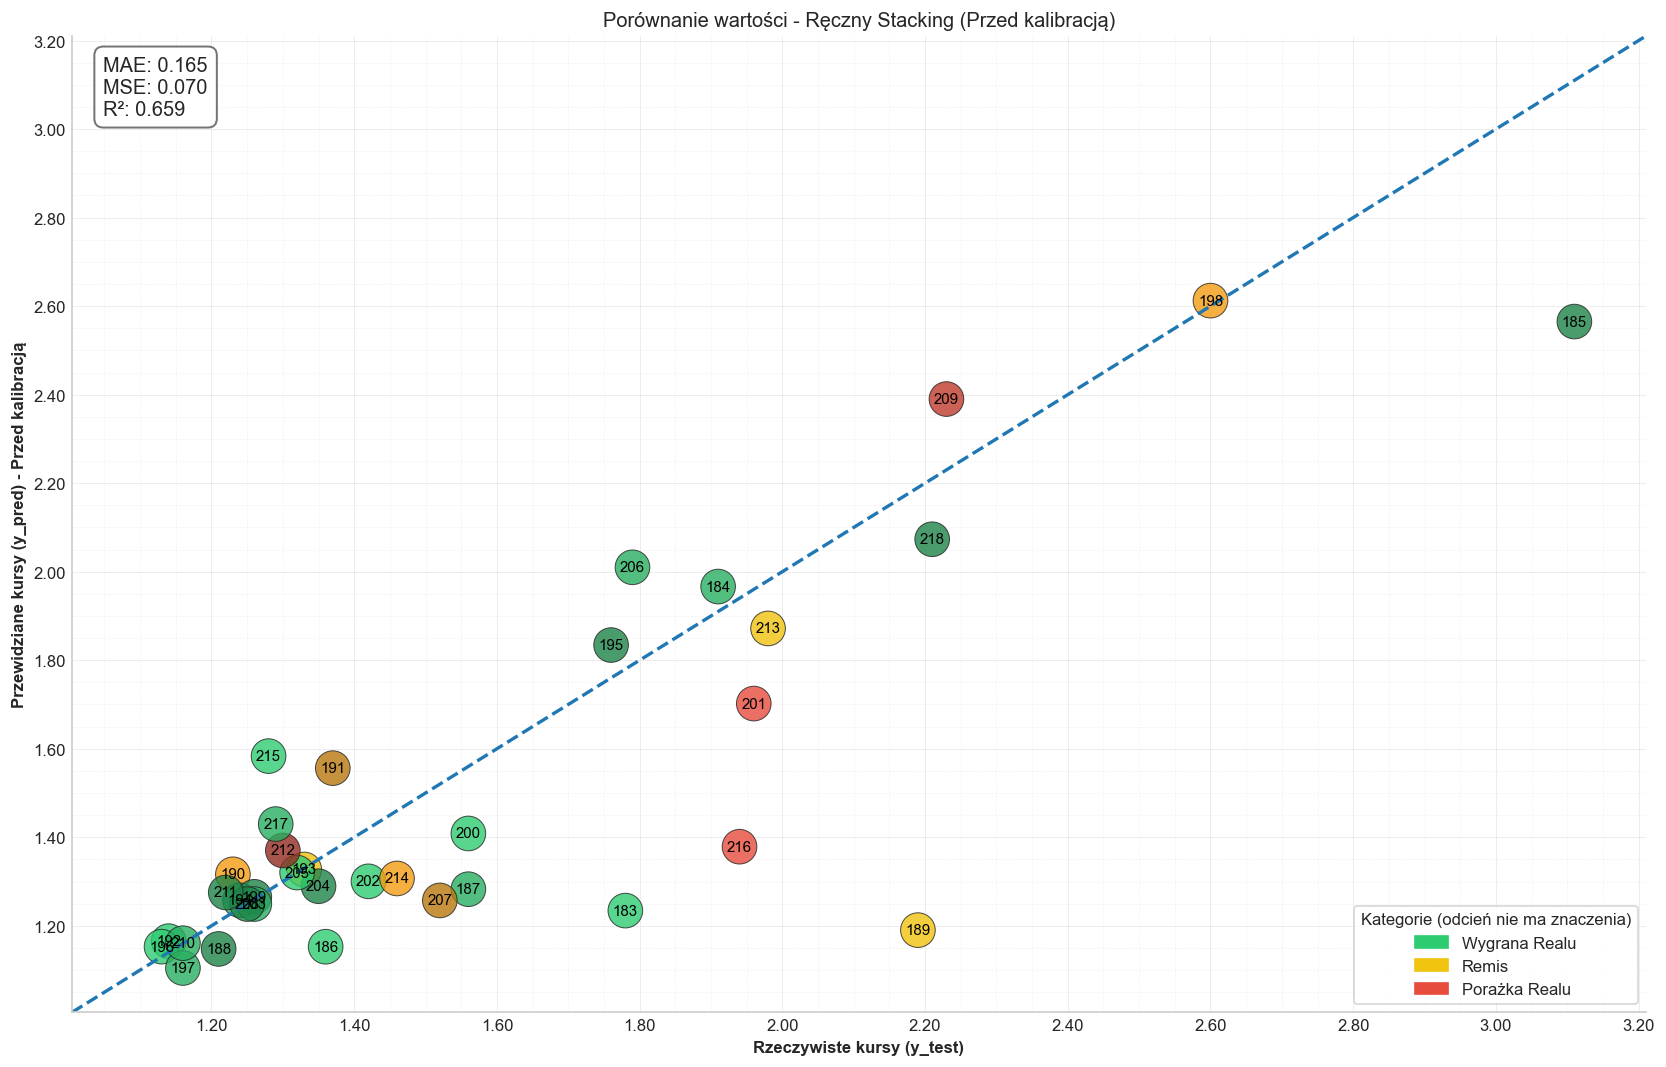

In [7]:
# ...existing code...
# --- KROK 4: Wizualizacja Wyników z Kontekstem ---

info("\nGenerowanie wizualizacji wyników z kolorowaniem...")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.patheffects as pe  # można usunąć, jeśli nie używasz path_effects
import matplotlib.patches as mpatches

# Kolory punktów wg wyniku meczu (różne odcienie w obrębie klas)
outcomes = test_metadata['is_real_madrid_win'].values
match_ids = test_metadata['MATCH_ID'].astype(str).values

def shaded_color_series(labels):
    palettes = {
        1: ['#2ecc71', '#27ae60', '#1e8449'],      # odcienie zieleni
        0.5: ['#f1c40f', '#f39c12', '#b9770e'],    # odcienie złota
        0: ['#e74c3c', '#c0392b', '#922b21'],      # odcienie czerwieni
    }
    counters = {1: 0, 0.5: 0, 0: 0}
    colors = []
    for lab in labels:
        pal = palettes.get(lab, ['#95a5a6'])
        idx = counters.get(lab, 0) % len(pal)
        colors.append(pal[idx])
        counters[lab] = counters.get(lab, 0) + 1
    return colors

point_colors = shaded_color_series(outcomes)
text_color_by_label = {1: 'black', 0.5: 'black', 0: 'black'}

# Zakresy osi (dla prognoz przed kalibracją)
x_min, x_max = float(np.min(y_test)), float(np.max(y_test))
y_min_pc, y_max_pc = float(np.min(y_pred_stack)), float(np.max(y_pred_stack))
lo_pc = min(x_min, y_min_pc)
hi_pc = max(x_max, y_max_pc)
pad_pc = 0.05 * (hi_pc - lo_pc) if hi_pc > lo_pc else 0.1
xmin_pc, xmax_pc = lo_pc - pad_pc, hi_pc + pad_pc
ymin_pc, ymax_pc = xmin_pc, xmax_pc  # symetrycznie względem y=x

# Dynamiczna gęstość podziałki
rng_pc = xmax_pc - xmin_pc
if rng_pc <= 1.0:
    major_pc, minor_pc = 0.05, 0.01
elif rng_pc <= 2.0:
    major_pc, minor_pc = 0.10, 0.02
else:
    major_pc, minor_pc = 0.20, 0.05

fig, ax = plt.subplots(figsize=(14, 9), dpi=120)
ax.set_axisbelow(True)  # siatka pod danymi

# Parametry czytelności (duże markery jak w kalibracji)
marker_size = int(360 * 1.2)  # 432
marker_alpha = 0.8
font_size = 9

# Punkty przed kalibracją (większe markery, półprzezroczyste)
ax.scatter(
    y_test, y_pred_stack,
    c=point_colors,
    alpha=marker_alpha,
    s=marker_size,
    edgecolors='#222',
    linewidths=0.6,
    zorder=2
)

# Etykiety MATCH_ID w środku punktów — bez obwódki
for x, y, mid, lab in zip(y_test, y_pred_stack, match_ids, outcomes):
    ax.text(
        x, y, mid,
        ha='center', va='center',
        fontsize=font_size,
        color=text_color_by_label.get(lab, 'white'),
        zorder=6,
        clip_on=False
    )

# Linia referencyjna y=x
ax.plot([xmin_pc, xmax_pc], [xmin_pc, xmax_pc], '--', color='#1f77b4', lw=2, label='Linia odniesienia (y = x)')

# Opisy i zakres
ax.set_xlim(xmin_pc, xmax_pc)
ax.set_ylim(ymin_pc, ymax_pc)
ax.set_xlabel("Rzeczywiste kursy (y_test)", fontweight='bold')
ax.set_ylabel("Przewidziane kursy (y_pred) - Przed kalibracją", fontweight='bold')
ax.set_title("Porównanie wartości - Ręczny Stacking (Przed kalibracją)")

# Formatowanie osi i siatki
ax.xaxis.set_major_locator(MultipleLocator(major_pc))
ax.yaxis.set_major_locator(MultipleLocator(major_pc))
ax.xaxis.set_minor_locator(AutoMinorLocator(int(major_pc/minor_pc)))
ax.yaxis.set_minor_locator(AutoMinorLocator(int(major_pc/minor_pc)))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.35, zorder=1)
ax.grid(which='minor', linestyle='--', linewidth=0.4, alpha=0.25, zorder=1)

# Legenda (bazowe barwy kategorii; odcień punktów nie ma znaczenia)
base_colors = {1: '#2ecc71', 0.5: '#f1c40f', 0: '#e74c3c'}
win_patch = mpatches.Patch(color=base_colors[1], label='Wygrana Realu')
draw_patch = mpatches.Patch(color=base_colors[0.5], label='Remis')
loss_patch = mpatches.Patch(color=base_colors[0], label='Porażka Realu')
ax.legend(
    handles=[win_patch, draw_patch, loss_patch],
    frameon=True,
    title='Kategorie (odcień nie ma znaczenia)'
)

# Metryki na wykresie (przed kalibracją) — większe okno i czcionka
try:
    ax.text(
        0.02, 0.98,
        f"MAE: {mae_stack:.3f}\nMSE: {mse_stack:.3f}\nR²: {r2_stack:.3f}",
        transform=ax.transAxes, va='top', ha='left',
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.45', facecolor='white', alpha=0.9, edgecolor='#666', linewidth=1.2),
        zorder=7
    )
except NameError:
    pass

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()

INFO: 
Generowanie wizualizacji wyników po kalibracji kursów...


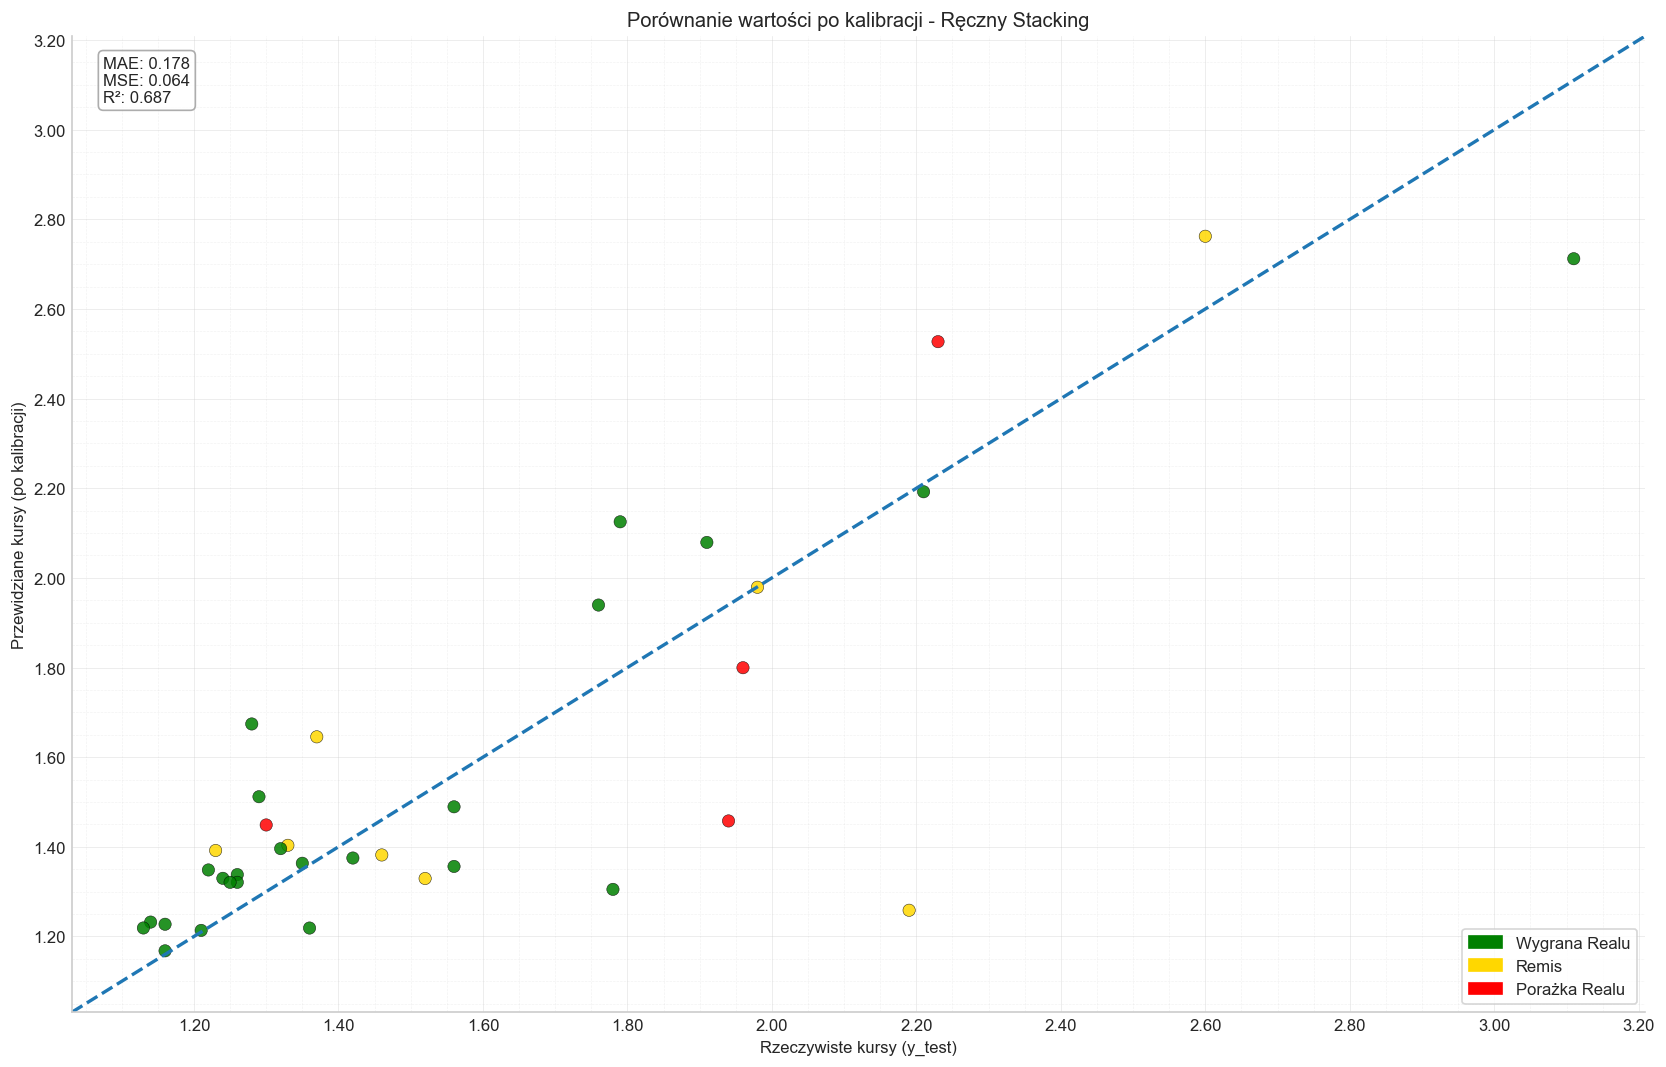

In [8]:

info("\nGenerowanie wizualizacji wyników po kalibracji kursów...")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter

# Kolory punktów wg wyniku meczu
color_map = {1: 'green', 0.5: 'gold', 0: 'red'}
point_colors = test_metadata['is_real_madrid_win'].map(color_map)

# Zakresy osi (dla prognoz po kalibracji)
x_min, x_max = float(np.min(y_test)), float(np.max(y_test))
y_min_c, y_max_c = float(np.min(y_pred_calibrated)), float(np.max(y_pred_calibrated))
lo_c = min(x_min, y_min_c)
hi_c = max(x_max, y_max_c)
pad_c = 0.05 * (hi_c - lo_c) if hi_c > lo_c else 0.1
xmin_c, xmax_c = lo_c - pad_c, hi_c + pad_c
ymin_c, ymax_c = xmin_c, xmax_c  # symetrycznie względem y=x

# Dynamiczna gęstość podziałki
rng_c = xmax_c - xmin_c
if rng_c <= 1.0:
    major_c, minor_c = 0.05, 0.01
elif rng_c <= 2.0:
    major_c, minor_c = 0.10, 0.02
else:
    major_c, minor_c = 0.20, 0.05

# Metryki po kalibracji
mse_stack_cal = mean_squared_error(y_test, y_pred_calibrated)
mae_stack_cal = mean_absolute_error(y_test, y_pred_calibrated)
r2_stack_cal = r2_score(y_test, y_pred_calibrated)

fig, ax = plt.subplots(figsize=(14, 9), dpi=120)

# Punkty po kalibracji
ax.scatter(y_test, y_pred_calibrated, c=point_colors, alpha=0.85, s=55, edgecolors='k', linewidths=0.3)

# Linia referencyjna y=x
ax.plot([xmin_c, xmax_c], [xmin_c, xmax_c], '--', color='#1f77b4', lw=2, label='Linia odniesienia (y = x)')

# Opisy i zakres
ax.set_xlim(xmin_c, xmax_c)
ax.set_ylim(ymin_c, ymax_c)
ax.set_xlabel("Rzeczywiste kursy (y_test)")
ax.set_ylabel("Przewidziane kursy (po kalibracji)")
ax.set_title("Porównanie wartości po kalibracji - Ręczny Stacking")

# Formatowanie osi i siatki
ax.xaxis.set_major_locator(MultipleLocator(major_c))
ax.yaxis.set_major_locator(MultipleLocator(major_c))
ax.xaxis.set_minor_locator(AutoMinorLocator(int(major_c/minor_c)))
ax.yaxis.set_minor_locator(AutoMinorLocator(int(major_c/minor_c)))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.35)
ax.grid(which='minor', linestyle='--', linewidth=0.4, alpha=0.25)

# Legenda
win_patch = mpatches.Patch(color='green', label='Wygrana Realu')
draw_patch = mpatches.Patch(color='gold', label='Remis')
loss_patch = mpatches.Patch(color='red', label='Porażka Realu')
ax.legend(handles=[win_patch, draw_patch, loss_patch], frameon=True)

# Metryki na wykresie (po kalibracji)
ax.text(0.02, 0.98, f"MAE: {mae_stack_cal:.3f}\nMSE: {mse_stack_cal:.3f}\nR²: {r2_stack_cal:.3f}",
        transform=ax.transAxes, va='top', ha='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='#999'))

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# Opcjonalnie zapisz obraz:
# plt.savefig(os.path.join(FileUtils.get_project_root(), 'img', 'LASSO+RFG+RIDGE_calibrated.png'), dpi=140)
plt.show()
# ...existing code...

INFO: 
Generowanie wizualizacji wyników po kalibracji kursów...


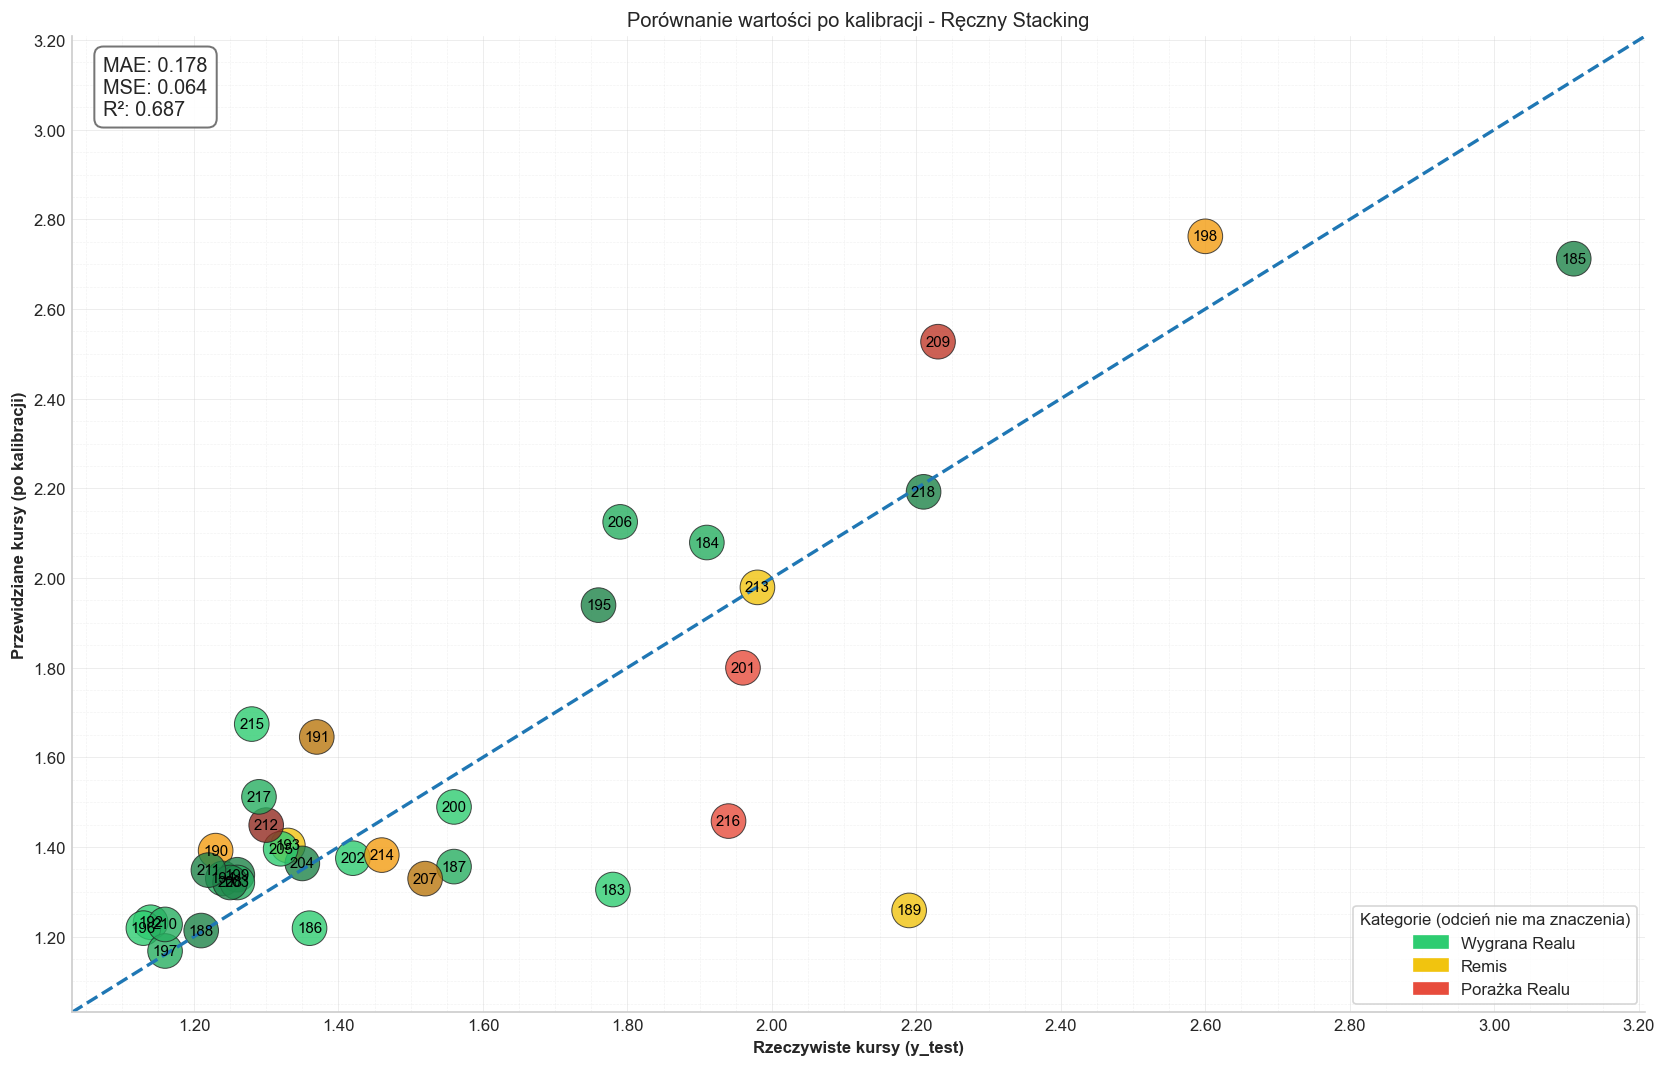

In [9]:
info("\nGenerowanie wizualizacji wyników po kalibracji kursów...")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.patheffects as pe  # można usunąć, jeśli nie używasz path_effects
import matplotlib.patches as mpatches

# Kolory punktów wg wyniku meczu (różne odcienie w obrębie klas)
outcomes = test_metadata['is_real_madrid_win'].values
match_ids = test_metadata['MATCH_ID'].astype(str).values

def shaded_color_series(labels):
    palettes = {
        1: ['#2ecc71', '#27ae60', '#1e8449'],      # odcienie zieleni
        0.5: ['#f1c40f', '#f39c12', '#b9770e'],    # odcienie złota
        0: ['#e74c3c', '#c0392b', '#922b21'],      # odcienie czerwieni
    }
    counters = {1: 0, 0.5: 0, 0: 0}
    colors = []
    for lab in labels:
        pal = palettes.get(lab, ['#95a5a6'])
        idx = counters.get(lab, 0) % len(pal)
        colors.append(pal[idx])
        counters[lab] = counters.get(lab, 0) + 1
    return colors

point_colors = shaded_color_series(outcomes)
text_color_by_label = {1: 'black', 0.5: 'black', 0: 'black'}

# Zakresy osi (dla prognoz po kalibracji)
x_min, x_max = float(np.min(y_test)), float(np.max(y_test))
y_min_c, y_max_c = float(np.min(y_pred_calibrated)), float(np.max(y_pred_calibrated))
lo_c = min(x_min, y_min_c)
hi_c = max(x_max, y_max_c)
pad_c = 0.05 * (hi_c - lo_c) if hi_c > lo_c else 0.1
xmin_c, xmax_c = lo_c - pad_c, hi_c + pad_c
ymin_c, ymax_c = xmin_c, xmax_c  # symetrycznie względem y=x

# Dynamiczna gęstość podziałki
rng_c = xmax_c - xmin_c
if rng_c <= 1.0:
    major_c, minor_c = 0.05, 0.01
elif rng_c <= 2.0:
    major_c, minor_c = 0.10, 0.02
else:
    major_c, minor_c = 0.20, 0.05

# Metryki po kalibracji
mse_stack_cal = mean_squared_error(y_test, y_pred_calibrated)
mae_stack_cal = mean_absolute_error(y_test, y_pred_calibrated)
r2_stack_cal = r2_score(y_test, y_pred_calibrated)

fig, ax = plt.subplots(figsize=(14, 9), dpi=120)
ax.set_axisbelow(True)  # siatka pod danymi

# Parametry czytelności (kropki x2 -> x2.4 po +20%)
marker_size = int(360 * 1.2)  # 432
marker_alpha = 0.8
font_size = 9

# Punkty po kalibracji (większe markery, niższy zorder, półprzezroczyste)
ax.scatter(
    y_test, y_pred_calibrated,
    c=point_colors,
    alpha=marker_alpha,
    s=marker_size,
    edgecolors='#222',
    linewidths=0.6,
    zorder=2
)

# Etykiety MATCH_ID w środku punktów (priorytet nad kropkami) — bez obwódki
for x, y, mid, lab in zip(y_test, y_pred_calibrated, match_ids, outcomes):
    ax.text(
        x, y, mid,
        ha='center', va='center',
        fontsize=font_size,
        color=text_color_by_label.get(lab, 'white'),
        zorder=6,
        clip_on=False
    )

# Linia referencyjna y=x
ax.plot([xmin_c, xmax_c], [xmin_c, xmax_c], '--', color='#1f77b4', lw=2, label='Linia odniesienia (y = x)')

# Opisy i zakres
ax.set_xlim(xmin_c, xmax_c)
ax.set_ylim(ymin_c, ymax_c)
ax.set_xlabel("Rzeczywiste kursy (y_test)", fontweight='bold')
ax.set_ylabel("Przewidziane kursy (po kalibracji)", fontweight='bold')
ax.set_title("Porównanie wartości po kalibracji - Ręczny Stacking")

# Formatowanie osi i siatki
ax.xaxis.set_major_locator(MultipleLocator(major_c))
ax.yaxis.set_major_locator(MultipleLocator(major_c))
ax.xaxis.set_minor_locator(AutoMinorLocator(int(major_c/minor_c)))
ax.yaxis.set_minor_locator(AutoMinorLocator(int(major_c/minor_c)))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.35, zorder=1)
ax.grid(which='minor', linestyle='--', linewidth=0.4, alpha=0.25, zorder=1)

# Legenda (bazowe barwy kategorii; odcień punktów nie ma znaczenia)
base_colors = {1: '#2ecc71', 0.5: '#f1c40f', 0: '#e74c3c'}
win_patch = mpatches.Patch(color=base_colors[1], label='Wygrana Realu')
draw_patch = mpatches.Patch(color=base_colors[0.5], label='Remis')
loss_patch = mpatches.Patch(color=base_colors[0], label='Porażka Realu')
ax.legend(
    handles=[win_patch, draw_patch, loss_patch],
    frameon=True,
    title='Kategorie (odcień nie ma znaczenia)'
)

# Metryki na wykresie (po kalibracji) — większe okno i czcionka
ax.text(
    0.02, 0.98,
    f"MAE: {mae_stack_cal:.3f}\nMSE: {mse_stack_cal:.3f}\nR²: {r2_stack_cal:.3f}",
    transform=ax.transAxes, va='top', ha='left',
    fontsize=12,
    bbox=dict(boxstyle='round,pad=0.45', facecolor='white', alpha=0.9, edgecolor='#666', linewidth=1.2),
    zorder=7
)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# Opcjonalnie zapisz obraz:
# plt.savefig(os.path.join(FileUtils.get_project_root(), 'img', 'LASSO+RFG+RIDGE_calibrated.png'), dpi